In [82]:
import pytorch_lightning as pl
from torch import unique
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
import os
import tqdm
import glob
from sklearn.model_selection import train_test_split
import torch.optim as optim
import wandb # Assuming this is imported at the top of your script
from Models3 import * ## self defined
from random_mask import get_random_mask

In [83]:
depth = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5]

def show_tensor_image2(img, depth=None):
    img = img.detach().cpu().numpy()
    img = np.squeeze(img)   # remove singleton dims

    # img can now be [7,H,W] or [H,W]
    if img.ndim == 2:
        img = img[None, ...]   # promote to [1,H,W]

    num_slices = img.shape[0]
    slice_positions = np.arange(num_slices)

    # Create subplots
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

    # Plot slices
    for i, pos in enumerate(slice_positions):
        slice_data = img[pos, :, :]

        im = axes[i].imshow(slice_data, vmin=0, vmax=0.32, cmap='jet')

        if depth is not None and len(depth) == num_slices:
            axes[i].set_title(f"Depth {depth[pos]} cm")
        else:
            axes[i].set_title(f"Slice {pos}")

        axes[i].axis('off')

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    cbar.set_label('Intensity')
    plt.show()

In [84]:
OBJECTS = np.load('Data4\\objects_random2.npy')
MASKS = np.load('Data4\\masks_random2.npy')
OPTICSES = np.load('Data4\\optics_random2.npy')
OPTICSES = np.concatenate([OPTICSES[:, :2], OPTICSES[:, :2]], axis=1)

N_Sample = OPTICSES.shape[0]

def Generate_Reconstruction_Image_Fast(n = N_Sample):
    sample_indxes = np.random.randint(0, n, size=16)
    return OBJECTS[sample_indxes],  MASKS[sample_indxes], OPTICSES[sample_indxes]

In [85]:

########################################
#   Loading Irregular shapes Dataset   #
########################################

base_path = r"C:\Users\aaron.l\PycharmProjects\DOT-AE-GAN\SIMULATION_to_PERTURBATION\output"

all_X_lesion, all_y_lesion, all_mask_lesion, all_optics_lesion, all_target_lesion = [], [], [], [], []

# Find all lesion folders
lesion_pattern = os.path.join(base_path, "lesion_*")
lesion_folders = glob.glob(lesion_pattern)

for folder_path in lesion_folders:
    folder_name = os.path.basename(folder_path)
    if folder_name.startswith("lesion_"):
        lesion_num = folder_name.split("_")[1]
        try:
            X = np.load(os.path.join(folder_path, f"All_measured_data_phan_lesion{lesion_num}.npy"))
            y = np.load(os.path.join(folder_path, f"All_ground_truth_phan_lesion{lesion_num}.npy"))
            mask = np.load(os.path.join(folder_path, f"All_fine_meshes_phan_lesion{lesion_num}.npy"))
            optics = np.load(os.path.join(folder_path, f"All_background_optics_phan_lesion{lesion_num}.npy"))
            target = np.load(os.path.join(folder_path, f"Target_depth_radius_phan_lesion{lesion_num}.npy"))
            all_X_lesion.append(X)
            all_y_lesion.append(y)
            all_mask_lesion.append(mask)
            all_optics_lesion.append(optics)
            all_target_lesion.append(target)
        except Exception as e:
            print(f"❌ Error loading lesion {lesion_num} at {folder_path}: {e}")

X_irregular = np.concatenate(all_X_lesion, axis=0)
y_irregular = np.concatenate(all_y_lesion, axis=0)
Mask_irregular = np.concatenate(all_mask_lesion, axis=0)
optics_irregular = np.concatenate(all_optics_lesion, axis=0)
target_irregular = np.concatenate(all_target_lesion, axis=0)

# N = X_irregular.shape[0]
# shuffled_indices = np.random.permutation(N)
#
# # 3. Apply the exact same shuffled indices to ALL arrays
# X_irregular = X_irregular[shuffled_indices]
# y_irregular = y_irregular[shuffled_indices]
# Mask_irregular = Mask_irregular[shuffled_indices]
# optics_irregular = optics_irregular[shuffled_indices]
# target_irregular = target_irregular[shuffled_indices]
#
print("size of X_irregular", X_irregular.shape)


size of X_irregular (2625, 18, 14)


In [86]:

######################################
#   Loading Regular shapes Dataset   #
######################################

X10 = np.load("Data3/all_rad_mua8/All_measured_data_phan.npy")
y10 = np.load("Data3/all_rad_mua8/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask10 = np.load("Data3/all_rad_mua8/All_fine_meshes_phan.npy")
optics10 = np.load("Data3/all_rad_mua8/All_background_optics_phan.npy")
target10 = np.load("Data3/all_rad_mua8/Target_depth_radius_phan.npy")


X11 = np.load("Data3/rad.75/All_measured_data_phan.npy")
y11 = np.load("Data3/rad.75/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask11 = np.load("Data3/rad.75/All_fine_meshes_phan.npy")
optics11 = np.load("Data3/rad.75/All_background_optics_phan.npy")
target11 = np.load("Data3/rad.75/Target_depth_radius_phan.npy")

X12 = np.load("Data3/rad.9/All_measured_data_phan.npy")
y12 = np.load("Data3/rad.9/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask12 = np.load("Data3/rad.9/All_fine_meshes_phan.npy")
optics12 = np.load("Data3/rad.9/All_background_optics_phan.npy")
target12 = np.load("Data3/rad.9/Target_depth_radius_phan.npy")

X13 = np.load("Data3/rad1.05/All_measured_data_phan.npy")
y13 = np.load("Data3/rad1.05/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask13 = np.load("Data3/rad1.05/All_fine_meshes_phan.npy")
optics13 = np.load("Data3/rad1.05/All_background_optics_phan.npy")
target13 = np.load("Data3/rad1.05/Target_depth_radius_phan.npy")

X14 = np.load("Data3/rad1.2/All_measured_data_phan.npy")
y14 = np.load("Data3/rad1.2/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask14 = np.load("Data3/rad1.2/All_fine_meshes_phan.npy")
optics14 = np.load("Data3/rad1.2/All_background_optics_phan.npy")
target14 = np.load("Data3/rad1.2/Target_depth_radius_phan.npy")


X15 = np.load("Data3/depth3.5/All_measured_data_phan.npy")
y15 = np.load("Data3/depth3.5/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask15 = np.load("Data3/depth3.5/All_fine_meshes_phan.npy")
optics15 = np.load("Data3/depth3.5/All_background_optics_phan.npy")
target15 = np.load("Data3/depth3.5/Target_depth_radius_phan.npy")


X16 = np.load("Data3/depthmrad.75/All_measured_data_phan.npy")
y16 = np.load("Data3/depthmrad.75/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask16 = np.load("Data3/depthmrad.75/All_fine_meshes_phan.npy")
optics16 = np.load("Data3/depthmrad.75/All_background_optics_phan.npy")
target16 = np.load("Data3/depthmrad.75/Target_depth_radius_phan.npy")

X17 = np.load("Data3/depthmrad.9/All_measured_data_phan.npy")
y17 = np.load("Data3/depthmrad.9/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask17 = np.load("Data3/depthmrad.9/All_fine_meshes_phan.npy")
optics17 = np.load("Data3/depthmrad.9/All_background_optics_phan.npy")
target17 = np.load("Data3/depthmrad.9/Target_depth_radius_phan.npy")

X18 = np.load("Data3/depthmrad1.05/All_measured_data_phan.npy")
y18 = np.load("Data3/depthmrad1.05/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask18 = np.load("Data3/depthmrad1.05/All_fine_meshes_phan.npy")
optics18 = np.load("Data3/depthmrad1.05/All_background_optics_phan.npy")
target18 = np.load("Data3/depthmrad1.05/Target_depth_radius_phan.npy")

X19 = np.load("Data3/depthmrad1.2/All_measured_data_phan.npy")
y19 = np.load("Data3/depthmrad1.2/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask19 = np.load("Data3/depthmrad1.2/All_fine_meshes_phan.npy")
optics19 = np.load("Data3/depthmrad1.2/All_background_optics_phan.npy")
target19 = np.load("Data3/depthmrad1.2/Target_depth_radius_phan.npy")


X20 = np.load("Data3/depthmrad.5/All_measured_data_phan.npy")
y20 = np.load("Data3/depthmrad.5/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask20 = np.load("Data3/depthmrad.5/All_fine_meshes_phan.npy")
optics20 = np.load("Data3/depthmrad.5/All_background_optics_phan.npy")
target20 = np.load("Data3/depthmrad.5/Target_depth_radius_phan.npy")


X21 = np.load("Data3/rad.5/All_measured_data_phan.npy")
y21 = np.load("Data3/rad.5/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask21 = np.load("Data3/rad.5/All_fine_meshes_phan.npy")
optics21 = np.load("Data3/rad.5/All_background_optics_phan.npy")
target21 = np.load("Data3/rad.5/Target_depth_radius_phan.npy")

X_spherical = np.concatenate([X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21], axis=0)
y_spherical = np.concatenate([y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21], axis=0)
Mask_spherical = np.concatenate([mask10, mask11, mask12, mask13, mask14, mask15, mask16, mask17, mask18, mask19, mask20, mask21], axis=0)
optics_spherical = np.concatenate([optics10, optics11, optics12, optics13, optics14, optics15, optics16, optics17, optics18, optics19, optics20, optics21], axis=0)
target_spherical = np.concatenate([target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20, target21], axis=0)

# N = X_spherical.shape[0]
# shuffled_indices = np.random.permutation(N)
#
# # 3. Apply the exact same shuffled indices to ALL arrays
# X_spherical = X_spherical[shuffled_indices]
# y_spherical = y_spherical[shuffled_indices]
# Mask_spherical = Mask_spherical[shuffled_indices]
# optics_spherical = optics_spherical[shuffled_indices]
# target_spherical = target_spherical[shuffled_indices]
#
# print("Data shuffled and aligned.")



In [87]:
######################################
#      Loading Phantom Dataset       #
######################################
X_phan = np.load("phan/All_measured_data_phan.npy")
y_phan = np.load("phan/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
Mask_phan = np.load("phan/All_fine_meshes_phan.npy")
optics_phan = np.load("phan/All_background_optics_phan.npy")
target_phan = np.load("phan/Target_depth_radius_phan.npy")

optics_phan = np.concatenate([optics_phan[:,:2], optics_phan[:,:2]], axis = 1)

In [88]:
##########################################
#          Combine both Dataset          #
##########################################

X = np.concatenate([X_spherical, X_irregular], axis=0)
y = np.concatenate([y_spherical, y_irregular], axis=0)
Mask = np.concatenate([Mask_spherical, Mask_irregular], axis=0)
optics = np.concatenate([optics_spherical, optics_irregular], axis=0)
target = np.concatenate([target_spherical, target_irregular], axis=0)


In [89]:
##############################################
#      3:1 Split on Spherical lesions        #
##############################################
(X_spherical_train, X_spherical_test,
 y_spherical_train, y_spherical_test,
 Mask_spherical_train, Mask_spherical_test,
 optics_spherical_train, optics_spherical_test,
 target_spherical_train, target_spherical_test) = train_test_split(
    X_spherical, y_spherical, Mask_spherical, optics_spherical, target_spherical,
    test_size=0.25, random_state=42
)

In [90]:
##############################################
#      3:1 Split on Irregular lesions        #
##############################################
(X_irregular_train, X_irregular_test,
 y_irregular_train, y_irregular_test,
 Mask_irregular_train, Mask_irregular_test,
 optics_irregular_train, optics_irregular_test,
 target_irregular_train, target_irregular_test) = train_test_split(
    X_irregular, y_irregular, Mask_irregular, optics_irregular, target_irregular,
    test_size=0.25, random_state=42
)

In [91]:

##########################################
#            Training Dataset            #
##########################################
X_train = np.concatenate([X_spherical_train, X_irregular_train], axis=0)
y_train = np.concatenate([y_spherical_train, y_irregular_train], axis=0)
Mask_train = np.concatenate([Mask_spherical_train, Mask_irregular_train], axis=0)
optics_train = np.concatenate([optics_spherical_train, optics_irregular_train], axis=0)
target_train = np.concatenate([target_spherical_train, target_irregular_train], axis=0)

In [92]:
##########################################
#            Testing Dataset             #
##########################################
X_test = np.concatenate([X_irregular_test, X_spherical_test], axis=0)
y_test = np.concatenate([y_irregular_test, y_spherical_test], axis=0)
Mask_test = np.concatenate([Mask_irregular_test, Mask_spherical_test], axis=0)
optics_test = np.concatenate([optics_irregular_test, optics_spherical_test], axis=0)
target_test = np.concatenate([target_irregular_test, target_spherical_test], axis=0)


In [93]:

##########################################
#           Lightening Dataset           #
##########################################

# Placeholder filter kernels (you must define these)
filter_kernel = np.array([[0.05, 0.1, 0.05], [0.1, 0.4, 0.1], [0.05, 0.1, 0.05]], dtype=np.float32)
filter_kernel2 = np.array([[0.05, 0.1, 0.05], [0.1, 0.4, 0.1], [0.05, 0.1, 0.05]], dtype=np.float32)

# Assuming you've already loaded and split your data into these variables:
# X_train, y_train, Mask_train, optics_train, tar_train (Combined train)
# X_test, y_test, Mask_test, optics_test, tar_test (Combined test)
# X_irregular, y_irregular, Mask_irregular, optics_irregular, target_irregular (Irregular-only)

import torch
import numpy as np
# Assuming 'convolve', 'filter_kernel', and 'filter_kernel2' are available

class MyDataset(Dataset):
    def __init__(self, X, y, Mask, optics, target, train=True):
        self.X = X              # Corresponds to self.X_train later
        self.y = y              # Corresponds to self.y_train later (Ground Truth Image)
        self.Mask = Mask        # Corresponds to self.Mask_train later
        self.optics = optics    # Corresponds to self.optics_train later
        self.target = target    # Corresponds to self.tar_train later (Condition data)
        self.train = train
        # print("shape of X: ", self.X.shape)
        # print("shape of y: ", self.y.shape)
        # print("shape of Mask: ", self.Mask.shape)
        # print("shape of optics: ", self.optics.shape)
        # print("shape of target: ", self.target.shape)
        # print("length of X: ", self.X.shape[0])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Use the correct instance variables
        X_sample = self.X[idx]
        y_image = self.y[idx]
        Mask_sample = self.Mask[idx]
        optics_sample = self.optics[idx]
        target_data = self.target[idx] # Get target data for the condition

        # Check if convolution should be applied
        if target_data[1] > 0.4:
            convolved_slices = []

            # ITERATE OVER EACH SLICE (y_image has shape [N_slices, H, W])
            for slice_idx in range(y_image.shape[0]):
                temp_2d = y_image[slice_idx] # Shape: [H, W]

                # Apply convolutions
                y_convolved = convolve(temp_2d, filter_kernel, mode='nearest')
                y_convolved = y_convolved + temp_2d
                y_convolved = convolve(y_convolved, filter_kernel2, mode='nearest')

                # Normalization logic
                max_val = np.max(y_convolved)
                y_convolved = (y_convolved / (1e-7 + max_val)) * np.max(temp_2d)

                convolved_slices.append(y_convolved)

            y_final = np.stack(convolved_slices, axis=0) # Shape: [N_slices, H, W]

        else:
            # FIX: If the condition is False, y_final must be the original image data (temp)
            y_final = y_image

        # Return the samples as PyTorch Tensors
        return (torch.Tensor(X_sample),
                torch.Tensor(Mask_sample),
                torch.Tensor(optics_sample),
                target_data, # This is a numpy array/list and does not need torch.Tensor conversion if it's metadata
                torch.Tensor(y_final))

In [94]:
##########################################
#            Phantom Dataset             #
##########################################

class myDataset_phan(Dataset):
    def __init__(self, train = True):
        self.X_train = X_phan# .reshape(-1, 18, 14)
        self.Mask_train = Mask_phan
        self.y_train = y_phan# .transpose((0, 3,1,2))
        self.train = train

        self.optics_train = optics_phan
        self.tar_train = target_phan
        # print("shape of X_train: ", self.X_train.shape)
        # print("shape of Mask_train: ", self.Mask_train.shape)
        # print("shape of y_train: ", self.y_train.shape)
        # print("shape of optics_train: ", self.optics_train.shape)
        # print("shape of tar_train: ", self.tar_train.shape)
        # print("length of X_train: ", self.X_train.shape[0])

    def __len__(self):
        if self.train:
            return len(self.X_train)

    # Correction for myDataset_phan.__getitem__
    def __getitem__(self, idx):
        if self.train:
            temp = self.y_train[idx]  # Shape: [N_slices, H, W]
            target_data = self.tar_train[idx]

            if target_data[1] > 0.4:
                convolved_slices = []

                # 💡 FIX: Iterate over the slices (Axis 0)
                for slice_idx in range(temp.shape[0]):
                    temp_2d = temp[slice_idx] # Shape: [H, W]. This is now 2D.

                    # 1. Apply convolutions to the 2D slice
                    y_convolved = convolve(temp_2d, filter_kernel, mode='nearest')
                    y_convolved = y_convolved + temp_2d
                    y_convolved = convolve(y_convolved, filter_kernel2, mode='nearest')

                    # 2. Apply the normalization logic to the 2D slice
                    max_val_convolved = y_convolved.max()
                    max_val_original = temp_2d.max()

                    # This normalization must now use max on the 2D arrays
                    y_convolved_norm = (y_convolved / (1e-7 + max_val_convolved)) * max_val_original

                    convolved_slices.append(y_convolved_norm)

                y_train_ = np.stack(convolved_slices, axis=0) # Re-stack into 3D: [N_slices, H, W]

                # Return the convolved tensor
                return (torch.Tensor(self.X_train[idx]),
                        torch.Tensor(self.Mask_train[idx]),
                        torch.Tensor(self.optics_train[idx]),
                        target_data,  # target_data is usually left as numpy/list/tuple
                        torch.Tensor(y_train_))

            else:
                # If condition is not met, return the original tensor (temp)
                return (torch.Tensor(self.X_train[idx]),
                        torch.Tensor(self.Mask_train[idx]),
                        torch.Tensor(self.optics_train[idx]),
                        target_data,
                        torch.Tensor(temp))

one_batch = next(iter(myDataset_phan()))
X_train_phan, Mask_train_phan, optics_train_phan, target_data_phan, tmp_phan = one_batch
print("shape of X_train_phan: ", X_train_phan.shape)
print("shape of Mask_train_phan: ", Mask_train_phan.shape)
print("shape of optics_train_phan: ", optics_train_phan.shape)
print("shape of target_data_phan: ", target_data_phan.shape)
print("shape of tmp_phan: ", tmp_phan.shape)

shape of X_train_phan:  torch.Size([18, 14])
shape of Mask_train_phan:  torch.Size([7, 32, 32])
shape of optics_train_phan:  torch.Size([4])
shape of target_data_phan:  (2,)
shape of tmp_phan:  torch.Size([7, 32, 32])


In [95]:
##########################################
#          Dataset Declaration           #
##########################################

train_dataset = MyDataset(
    X_train, y_train, Mask_train, optics_train, target_train, train=True
)

test_dataset = MyDataset(
    X_test, y_test, Mask_test, optics_test, target_test, train=False
)

test_phan_dataset = myDataset_phan()

print("shape of X_test: ", X_test.shape)
print("shape of y_test: ", y_test.shape)
print("shape of Mask_test: ", Mask_test.shape)
print("shape of optics_test: ", optics_test.shape)
print("target_test.shape: ", target_test.shape)

print("\n\n")

print("shape of X_train: ", X_train.shape)
print("shape of y_train: ", y_train.shape)
print("shape of Mask_train: ", Mask_train.shape)
print("shape of optics_train: ", optics_train.shape)
print("target_train.shape: ", target_train.shape)


shape of X_test:  (6540, 18, 14)
shape of y_test:  (6540, 7, 32, 32)
shape of Mask_test:  (6540, 7, 32, 32)
shape of optics_test:  (6540, 4)
target_test.shape:  (6540, 2)



shape of X_train:  (19615, 18, 14)
shape of y_train:  (19615, 7, 32, 32)
shape of Mask_train:  (19615, 7, 32, 32)
shape of optics_train:  (19615, 4)
target_train.shape:  (19615, 2)


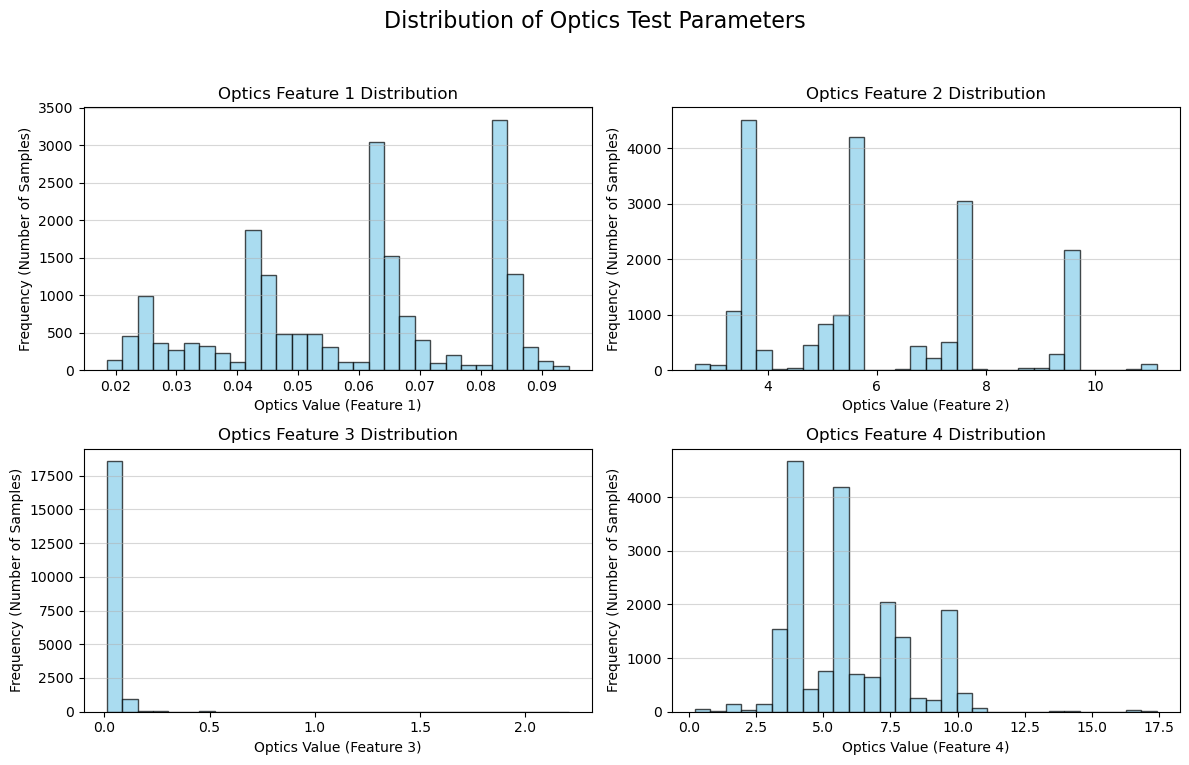

N features:  4

--- Detailed Sample Counts Per Bin ---

Feature 1:
  Range [0.0186 to 0.0211): 135 samples
  Range [0.0211 to 0.0236): 456 samples
  Range [0.0236 to 0.0261): 984 samples
  Range [0.0261 to 0.0287): 369 samples
  Range [0.0287 to 0.0312): 273 samples
  Range [0.0312 to 0.0337): 359 samples
  Range [0.0337 to 0.0363): 328 samples
  Range [0.0363 to 0.0388): 231 samples
  Range [0.0388 to 0.0413): 112 samples
  Range [0.0413 to 0.0439): 1873 samples
  Range [0.0439 to 0.0464): 1266 samples
  Range [0.0464 to 0.0489): 481 samples
  Range [0.0489 to 0.0515): 482 samples
  Range [0.0515 to 0.0540): 486 samples
  Range [0.0540 to 0.0565): 310 samples
  Range [0.0565 to 0.0591): 108 samples
  Range [0.0591 to 0.0616): 105 samples
  Range [0.0616 to 0.0641): 3041 samples
  Range [0.0641 to 0.0666): 1529 samples
  Range [0.0666 to 0.0692): 724 samples
  Range [0.0692 to 0.0717): 407 samples
  Range [0.0717 to 0.0742): 94 samples
  Range [0.0742 to 0.0768): 201 samples
  Range [0

In [96]:
##########################################
#            Optics Property             #
##########################################
import numpy as np
import matplotlib.pyplot as plt

# Assuming optics_train is a NumPy array or PyTorch tensor converted to NumPy
# If it's a tensor, make sure it's converted before this code runs:
# optics_train = optics_train.cpu().numpy()

# Assuming optics_train has shape (N_samples, 4)
N_features = optics_train.shape[1]
N_BINS = 30 # Defines the number of bins used for both the plot and the printout

# --- Visualization Code ---
plt.figure(figsize=(12, 8))
plt.suptitle("Distribution of Optics Test Parameters", fontsize=16)

# Iterate through each of the 4 features
for i in range(N_features):
    # Create a subplot for each feature
    plt.subplot(2, 2, i + 1)

    # Plot the histogram
    plt.hist(optics_train[:, i], bins=N_BINS, alpha=0.7, color='skyblue', edgecolor='black')

    # Label the plot.
    plt.title(f'Optics Feature {i+1} Distribution')
    plt.xlabel(f'Optics Value (Feature {i+1})')
    plt.ylabel('Frequency (Number of Samples)')
    plt.grid(axis='y', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

print("N features: ", N_features)

# --- Detailed Sample Counts Per Bin ---
print("\n--- Detailed Sample Counts Per Bin ---")

for i in range(N_features):
    feature_data = optics_train[:, i]

    # Calculate counts and bin edges using np.histogram
    counts, bin_edges = np.histogram(feature_data, bins=N_BINS)

    print(f"\nFeature {i+1}:")

    # Iterate over the bins and print the range and count
    for j in range(len(counts)):
        bin_start = bin_edges[j]
        bin_end = bin_edges[j+1]
        count = counts[j]

        # Only print bins that have samples (count > 0) for cleaner output
        if count > 0:
            # Use 4 decimal places for precision on the optics values
            print(f"  Range [{bin_start:.4f} to {bin_end:.4f}): {count} samples")


In [97]:
##########################################
#         Dataloader Declaration         #
##########################################

BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

phan_dataloader = DataLoader(test_phan_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)


In [98]:
##########################################
#           Visualization Code           #
##########################################

first_bacth = next(iter(test_dataloader))
first_x_data, first_mask_data, first_optics_data, first_target_data, first_y_final = first_bacth
# print("first data shape: ", first_x_data.shape)
# print("first mask shape: ", first_mask_data.shape)
# print("first optics shape: ", first_optics_data.shape)
# print("first target shape: ", first_target_data.shape)
# print("first y shape: ", first_y_final.shape)
def show_tensor_image2(img, depth=None):
    img = img.detach().cpu().numpy()
    img = np.squeeze(img)   # remove singleton dims

    # img can now be [7,H,W] or [H,W]
    if img.ndim == 2:
        img = img[None, ...]   # promote to [1,H,W]

    num_slices = img.shape[0]
    slice_positions = np.arange(num_slices)

    # Create subplots
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

    # Plot slices
    for i, pos in enumerate(slice_positions):
        slice_data = img[pos, :, :]

        im = axes[i].imshow(slice_data, vmin=0, vmax=0.32, cmap='jet')

        if depth is not None and len(depth) == num_slices:
            axes[i].set_title(f"Depth {depth[pos]} cm")
        else:
            axes[i].set_title(f"Slice {pos}")

        axes[i].axis('off')

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    cbar.set_label('Intensity')
    plt.show()


Accessing the first batch...
Iterating over the first 5 data points...

--- Plotting Data Point 1 ---


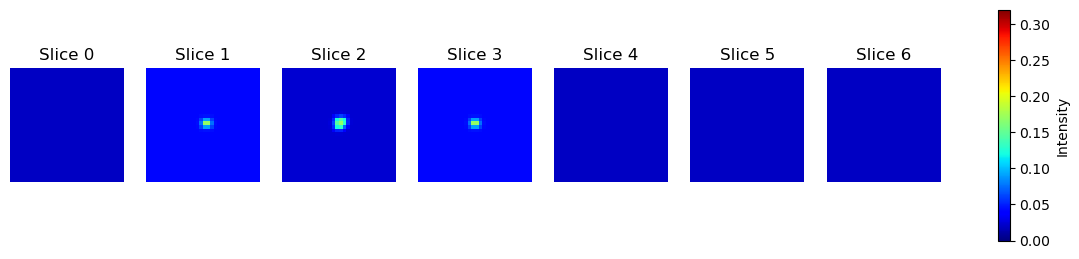

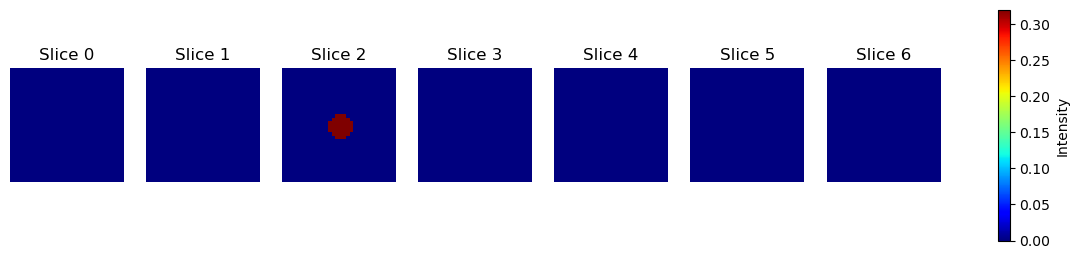


--- Plotting Data Point 2 ---


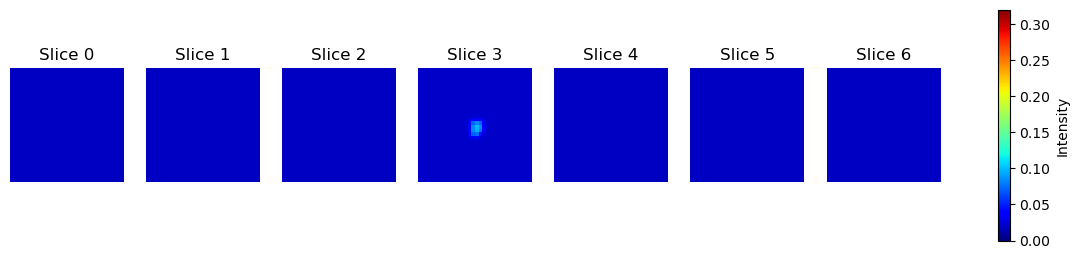

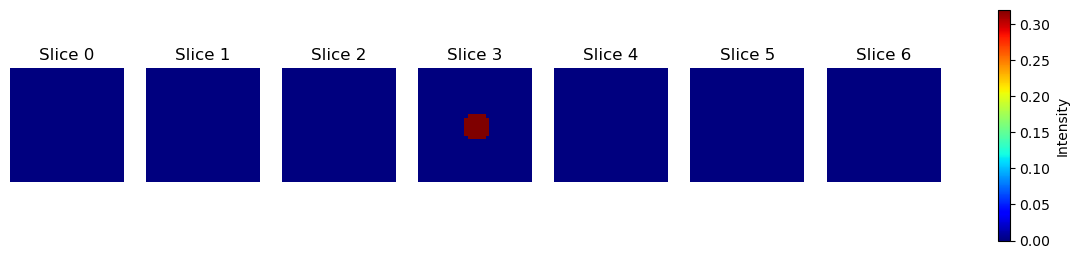


--- Plotting Data Point 3 ---


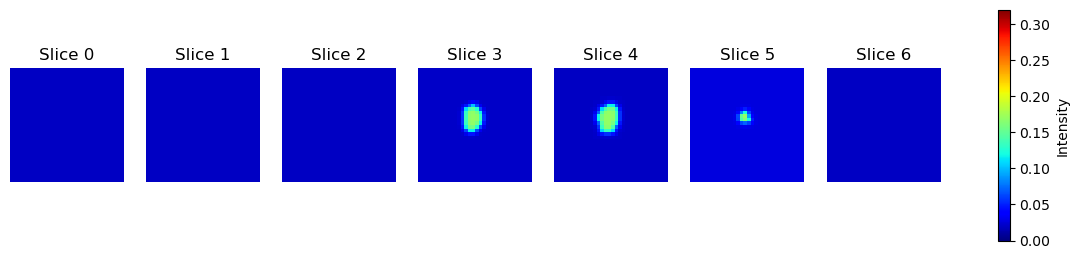

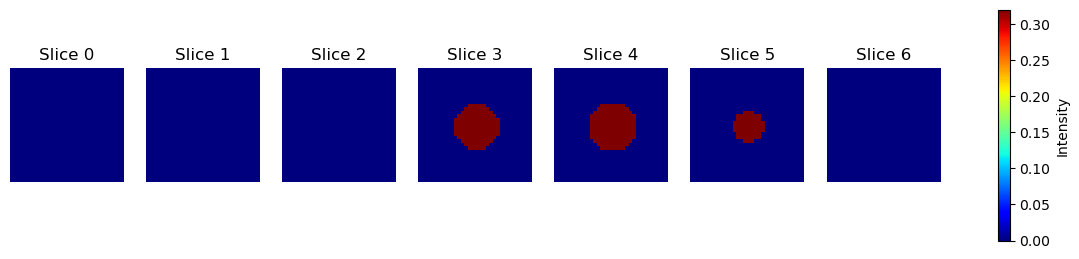


--- Plotting Data Point 4 ---


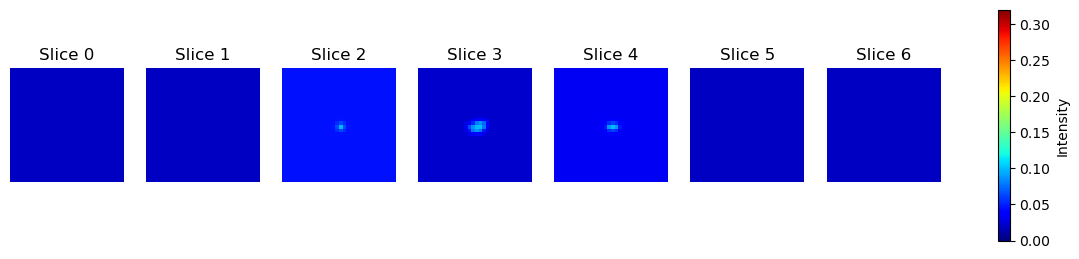

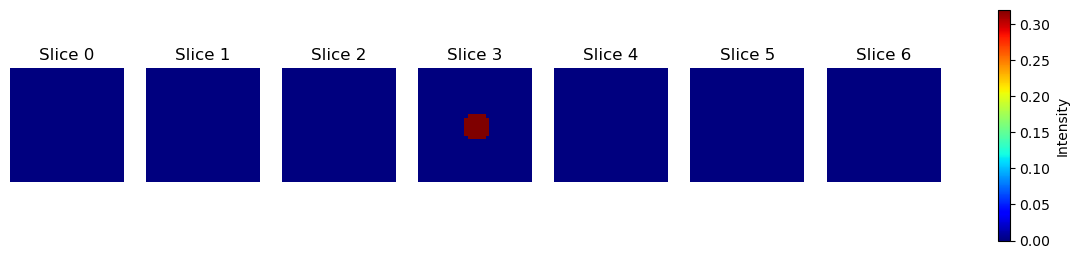


--- Plotting Data Point 5 ---


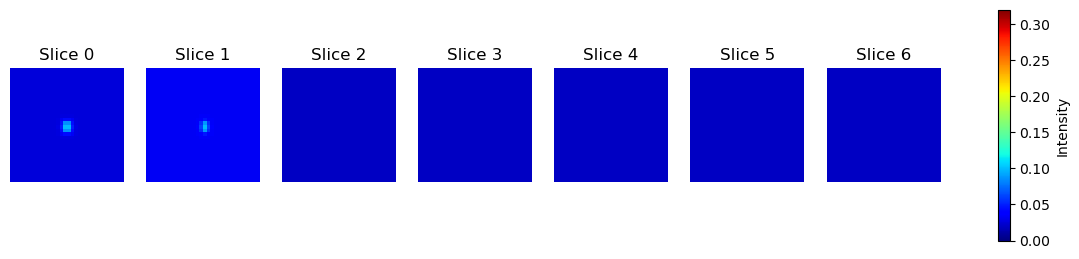

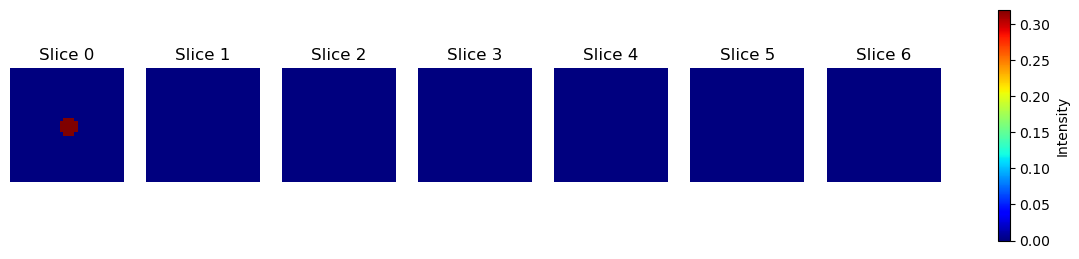

In [99]:
print("Accessing the first batch...")
first_batch = next(iter(test_dataloader))
# Unpack the batch components
x_data, mask_data_batch, optics_data, target_data, y_final_data = first_batch

num_datapoints_to_plot = 5
batch_size = x_data.shape[0]

print(f"Iterating over the first {min(num_datapoints_to_plot, batch_size)} data points...")

for i in range(min(num_datapoints_to_plot, batch_size)):
    print(f"\n--- Plotting Data Point {i+1} ---")

    # Get the data for the i-th item
    gt_images = y_final_data[i]     # Shape: [7, 32, 32]
    # FIX: Use a new variable name (e.g., 'mask_data_item') to hold the 3D tensor
    mask_data_item = mask_data_batch[i]    # Shape: [7, 32, 32]

    # --- Graph the Ground Truth (GT) ---
    # We only want the first 5 slices (images) for a standard comparison
    # Slicing the 7 slices to get the first 5:
    gt_first_five_slices = gt_images[:, :, :].unsqueeze(0) # Reshape to [1, 5, 32, 32] for the function
    show_tensor_image2(
        gt_first_five_slices,
    )

    # --- Graph the Reconstruction (Recon) ---
    # FIX: Use the new variable 'mask_data_item' for indexing
    recon_first_five_slices = mask_data_item[:, :, :].unsqueeze(0) # Reshape to [1, 5, 32, 32]
    show_tensor_image2(
        recon_first_five_slices,
    )

In [100]:
##########################################
#           Visualization Code           #
##########################################

import torch
import matplotlib.pyplot as plt

def graph_first_five_multi_slice(epoch, inverse_model, test_dataloader, device="cpu"):
    """
    Builds a figure showing 5 samples × 7 slices:
    rows: [GT, Recon] per sample; columns: slices
    RETURNS: (fig) so caller can send to wandb and then close it.
    """
    inverse_model.eval()

    VMIN, VMAX = 0, 0.32
    CMAP = 'jet'
    N_SLICES = 7
    N_SAMPLES = 5

    try:
        first_batch = next(iter(test_dataloader))
        X, Mask, Optics, _, Y_GT_batch = first_batch

        if Y_GT_batch.shape[0] < N_SAMPLES:
            N_SAMPLES = Y_GT_batch.shape[0]

        if Y_GT_batch.shape[1] < N_SLICES:
            N_SLICES = Y_GT_batch.shape[1]

        X = X.to(device).float()
        Mask = Mask.to(device).float()
        Optics = Optics.to(device).float()
        Y_GT_batch = Y_GT_batch.to(device).float()

    except StopIteration:
        print("Error: The dataloader is empty.")
        return None
    except Exception as e:
        print(f"Batch retrieval error: {e}")
        return None

    with torch.no_grad():
        Y_Recon_batch = inverse_model(Mask, X, Optics)

    Y_GT_samples = Y_GT_batch[:N_SAMPLES].cpu().numpy()
    Y_Recon_samples = Y_Recon_batch[:N_SAMPLES].cpu().numpy()

    fig, axes = plt.subplots(
        2 * N_SAMPLES, N_SLICES,
        figsize=(2.5 * N_SLICES, 2.5 * 2 * N_SAMPLES),
        gridspec_kw={'wspace': 0.05, 'hspace': 0.05},
        dpi=120
    )
    fig.suptitle(f"Epoch {epoch}: Ground Truth vs. Reconstruction (First {N_SAMPLES} Samples)",
                 fontsize=16, y=0.98)

    im_recon = None
    for i in range(N_SAMPLES):
        gt_row = 2 * i
        recon_row = 2 * i + 1
        for j in range(N_SLICES):
            ax_gt = axes[gt_row, j]
            ax_gt.imshow(Y_GT_samples[i, j], vmin=VMIN, vmax=VMAX, cmap=CMAP)
            ax_gt.axis('off')
            if j == 0:
                ax_gt.text(-5, 16, f"Sample {i+1}\nGT", ha='right', va='center',
                           fontsize=10, weight='bold')

            ax_recon = axes[recon_row, j]
            im_recon = ax_recon.imshow(Y_Recon_samples[i, j], vmin=VMIN, vmax=VMAX, cmap=CMAP)
            ax_recon.axis('off')
            if j == 0:
                ax_recon.text(-5, 16, "Recon", ha='right', va='center', fontsize=10)

            if i == 0:
                ax_gt.set_title(f"Slice {j}", fontsize=10)

    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.94, 0.1, 0.015, 0.8])
    if im_recon is not None:
        fig.colorbar(im_recon, cax=cbar_ax, label='Intensity')

    return fig  # 🔑 return, don’t show/close here


In [101]:
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [102]:
##########################################
#             Image Plotting             #
##########################################

def sample_plot_image_all(model):
    for step, (batchmeasured, batch_mask,b_opt, b_tar, batch_actual_image) in enumerate(test_dataloader):
        batchmeasured = batchmeasured.to(device) #.view(-1, 18, 14)
        batch_actual_image = batch_actual_image.to(device) #.view(-1, 7, 32, 32)
        batch_mask = batch_mask.to(device)
        b_opt = b_opt.to(device)
        pred_reconstruction = model(batch_mask, batchmeasured, b_opt)

        mask_ran = get_random_mask(b_tar.numpy(), batch_actual_image.cpu().numpy())
        mask_ran = torch.tensor(mask_ran, dtype = torch.float32, device = device)
        #mask_ran = mask_ran* mask.max(dim = (2, 3))

        show_tensor_image2(batch_actual_image)
        show_tensor_image2(mask_ran)
        show_tensor_image2(pred_reconstruction.detach())

def sample_plot_image(model):
    for step, (batchmeasured, batch_mask, b_opt, b_tar, batch_actual_image) in enumerate(test_dataloader):
        batchmeasured = batchmeasured.to(device) #.view(-1, 18, 14)
        batch_actual_image = batch_actual_image.to(device) #.view(-1, 7, 32, 32)
        batch_mask = batch_mask.to(device)
        b_opt = b_opt.to(device)
        pred_reconstruction = model(batch_mask, batchmeasured, b_opt)
        mask_ran = get_random_mask(b_tar.numpy(), batch_actual_image.cpu().numpy())

        mask_ran = torch.tensor(mask_ran, dtype = torch.float32, device = device)
        #mask_ran = mask_ran* mask.max(dim = (2, 3))

        show_tensor_image2(batch_actual_image)
        show_tensor_image2(mask_ran)
        show_tensor_image2(pred_reconstruction.detach())
        break

In [103]:
##########################################
#             Error Plotting             #
##########################################

import matplotlib.pyplot as plt
import numpy as np

def error_plot(predictions, corresponding_ground_truth, epoch):

    print("length of corresponding_ground_truth: ", len(corresponding_ground_truth))
    print("unique values of corresponding_ground_truth: ", np.unique(corresponding_ground_truth))
    print("length of predictions: ", len(predictions))
    predictions = np.array(predictions)
    corresponding_ground_truth = np.round(np.array(corresponding_ground_truth), 3)
    ground_truth = np.sort(np.unique(corresponding_ground_truth))

    data_dict = {value: [] for value in ground_truth}
    for gt_value in ground_truth:
        cond = (corresponding_ground_truth > (gt_value - 0.001)) & (corresponding_ground_truth < (gt_value + 0.001))
        pred_for_value = predictions[cond]
        if len(pred_for_value) > 0:
            data_dict[gt_value].extend(pred_for_value)

    boxplot_data = [data_dict[gt_value] for gt_value in ground_truth if len(data_dict[gt_value]) > 0]
    filtered_ground_truth = [gt_value for gt_value in ground_truth if len(data_dict[gt_value]) > 0]

    fig, ax = plt.subplots(figsize=(14, 8))

    box = ax.boxplot(boxplot_data, positions=filtered_ground_truth, widths=0.005, patch_artist=True, showfliers=False)

    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
    for patch, color in zip(box['boxes'], colors * int(np.ceil(len(box['boxes'])/len(colors)))):
        patch.set_facecolor(color)

    for whisker in box['whiskers']:
        whisker.set(color='#7570b3', linewidth=1.5)

    for cap in box['caps']:
        cap.set(color='#7570b3', linewidth=1.5)

    for median in box['medians']:
        median.set(color='red', linewidth=2)

    for flier in box['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

    ax.scatter(corresponding_ground_truth, predictions, color='r', alpha=0.6, s=10)

    ax.set_xlabel('Ground Truth Values')
    ax.set_ylabel('Prediction Values')
    ax.set_title(f'Boxplot of Predictions vs Ground Truth Values (Epoch {epoch})')
    ax.grid(True)

    ax.set_xlim(0.08, 0.32)
    ax.set_xticks(filtered_ground_truth)
    ax.set_xticklabels([f'{val:.3f}' for val in filtered_ground_truth], rotation=45, ha='right')

    return fig  # 🔑 return figure instead of showing

# Example data
# ground_truth = np.arange(0.12, 0.31, 0.015)
# predictions = np.random.random(100)  # Example predictions
# corresponding_ground_truth = np.random.choice(ground_truth, 100)  # Example corresponding ground truth values
# print("predictions.shape: ", predictions.shape)
# print("corresponding_ground_truth.shape: ", corresponding_ground_truth.shape)
# error_plot(predictions, corresponding_ground_truth)

In [104]:
##########################################
#                MSE Error               #
##########################################
from sklearn.metrics import r2_score

import torch.nn.functional as F

def mse_error(x, x_head, mask):
    # 1. Calculate the overall batch MSE loss (pixel-wise, masked)
    gt_masked = x * mask
    recon_masked = x_head * mask
    batch_mse = F.mse_loss(gt_masked, recon_masked)

    # 2. Compute the per-sample maximums (16 values)
    # Get max over spatial dims (H, W), shape [B, C] -> [16, 7]
    gt_max_spatial = gt_masked.amax(dim=[-1, -2])
    recon_max_spatial = recon_masked.amax(dim=[-1, -2])

    # Get max over slices (C), shape [B] -> [16]
    gt_max_per_sample = gt_max_spatial.amax(dim=1).detach().cpu().tolist()
    recon_max_per_sample = recon_max_spatial.amax(dim=1).detach().cpu().tolist()

    # Return: (Loss, list of 16 GT maxes, list of 16 Recon maxes)
    return batch_mse, gt_max_per_sample, recon_max_per_sample

In [105]:
##########################################
#          Perturbation Plotting         #
##########################################
def scatter_plot_pert(pred_pert, optics_gen):
    # plt.scatter(All_measured_data[i][:9], All_measured_data[i][9:])
    # plt.show()

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Create and add the circle to the axis
    circle = plt.Circle((0, 0), 1, edgecolor='b', facecolor='none')
    ax.add_patch(circle)

    # # Plot the scatter data
    # for data in All_measured_data:
    #     ax.scatter(data[0], data[1])
    pred_per = pred_pert[0].detach().cpu().numpy()

    # #for i in range(0,1):
    ax.scatter(pred_per[:9],pred_per[9:] )
    # print("Mua target", All_ground_truth[i].max())
    # print("Depth, Radius", Target_depth_radius[i])

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Set limits to ensure the circle is centered and visible
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    # Add grid for better visualization
    ax.grid(True)

    # Display the plot
    plt.show()
    #break

In [106]:
##########################################
#            Model Declaration           #
##########################################
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
inverse_model = Inverse_Operator().to(device)
# inverse_model.load_state_dict(torch.load('normal_checkpoints/checkpoints_epoch150/model_weights_inverse_operator_best.pth'))
forward_model = Forward_Operator().to(device)
# forward_model.load_state_dict(torch.load('normal_checkpoints/checkpoints_epoch150/model_weights_forward_operator_best.pth'))
dis = Discriminator(input_shape=7520).to(device)
# dis.load_state_dict(torch.load('normal_checkpoints/checkpoints_epoch150/model_weights_discriminator_best.pth'))

In [107]:
##########################################
#         Optimizer Configuration        #
##########################################
# device = "cuda" if torch.cuda.is_available() else "cpu"
# inverse_model = Inverse_Operator().to(device)
# forward_model = Forward_Operator().to(device)
# dis = Discriminator().to(device)
opt_inverse = optim.Adam(inverse_model.parameters(), lr = 0.00002, betas = (0.5, 0.999))
opt_forward = optim.Adam(forward_model.parameters(), lr = 0.00002, betas = (0.5, 0.999))
opt_dis = optim.Adam(dis.parameters(), lr = 0.00002, betas = (0.5, 0.999))
mask[mask<1].shape


(429540,)

In [108]:
##########################################
#            Loss Function               #
##########################################
import torch
import torch.nn.functional as F
import torch.nn as nn


def Weighted_Loss(x, x_head, mask):
    # Compute the maximum value over the last two dimensions sequentially
    x_max = x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]

    # Normalize the input tensors by the maximum value
    x_normalized = x / (x_max + 1e-6) * mask
    x_head_normalized = x_head / (x_max + 1e-6)* mask

    #mask_ind = mask<0.01

    # Compute and return the L1 loss
    return F.l1_loss(x, x_head) + F.l1_loss(x_normalized, x_head_normalized) #  + F.l1_loss(x_head[mask_ind],mask[mask_ind])

# Example usage
loss = Weighted_Loss(torch.randn(2, 7, 32, 32), torch.randn(2, 7, 32, 32), torch.randn(2, 7, 32, 32))
# print(loss)


bce = nn.BCEWithLogitsLoss()

In [109]:
import wandb
from sklearn.metrics import r2_score

def test_fn(inverse_model, loader, epoch, device):
    inverse_model.eval()
    pbart = tqdm.tqdm(loader, leave=True)
    mselosses = 0
    gt_max, pred_max = [], []

    with torch.no_grad():
        for idx, (pert_label, mask, b_optics, b_tar, Mua_Ground_Truth) in enumerate(pbart):
            pert_label = pert_label.to(device)
            mask = mask.to(device)
            b_optics = b_optics.to(device)
            Mua_Ground_Truth = Mua_Ground_Truth.to(device)
            mask_ran = mask

            Mua_Recons = inverse_model(mask, pert_label, b_optics)
            mse, gt_list, pred_list = mse_error(Mua_Ground_Truth, Mua_Recons, mask_ran)

            gt_max.extend(gt_list)
            pred_max.extend(pred_list)

            mselosses += mse.item()

            if idx % 10 == 0:
                pbart.set_postfix(Mean_Square_Error=mse.item())

    if epoch % 3 == 0:

        fig = error_plot(pred_max, gt_max, epoch)
        wandb.log({f"Boxplot Predictions vs GT (Epoch {epoch})": wandb.Image(fig)}, step=epoch)
        plt.close(fig)  # 🔑 close to avoid memory leak

    return mselosses / len(pbart), r2_score(gt_max, pred_max)

In [110]:
##########################################
#            Train Function              #
##########################################

def train_fn(inverse_model, forward_model, dis, loader, opt_inverse, opt_forward, opt_dis, epoch, device):
    inverse_model.train() # Ensure training mode
    forward_model.train()
    dis.train()
    pbar = tqdm.tqdm(loader, leave=True)

    # Initialize loss accumulators
    epoch_p2p_loss_pert = 0
    epoch_p2p_loss_recons = 0
    epoch_r2r_loss_recons = 0
    epoch_d_fake = 0
    epoch_d_fake2 = 0
    epoch_d_real = 0
    epoch_r2r_g_fake_loss = 0

    for idx, (pert_label, mask, b_optics, b_tar, Mua_Ground_Truth) in enumerate(pbar):
        # Determine the current batch size dynamically
        batch_size = Mua_Ground_Truth.shape[0]

        pert_label = pert_label.to(device) # input tabular type
        mask = mask.to(device) # target image type
        mask_ran = mask
        b_optics = b_optics.to(device)
        Mua_Ground_Truth = Mua_Ground_Truth.to(device)

        ## Train Perturbation to Perturbation (P2P) model
        ##########################################
        Mua_Recons = inverse_model(mask_ran, pert_label, b_optics)
        pert_pred = forward_model(Mua_Recons, b_optics)

        # Loss: P2P
        loss_pert = F.l1_loss(pert_label[:,:18,:], pert_pred)
        loss_recons1 = Weighted_Loss(Mua_Ground_Truth*mask_ran, Mua_Recons, mask_ran) * 1.5
        loss_recons = loss_recons1 + loss_pert

        # Discriminator Input Features (Robust Concatenation)
        # Bx2 -> Bx40 | Bx1 -> Bx60
        optics_repeated = b_optics[:, :2].repeat(1, 20)
        mua_max_repeated_gt = Mua_Ground_Truth.amax(dim=[1, 2, 3]).unsqueeze(1).repeat(1, 60)

        ### Train the discriminator (P2P path)
        D_real = dis(mask_ran, pert_label, torch.cat([optics_repeated, mua_max_repeated_gt], dim=1))
        D_real_loss = bce(D_real, torch.ones_like(D_real))

        pert_pred_noisy = pert_pred + torch.randn_like(pert_pred) * 0.25
        D_fake = dis(mask_ran, pert_pred_noisy.detach(), torch.cat([optics_repeated, mua_max_repeated_gt], dim=1))
        D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))

        # Weight update for the inverse operator (P2P)
        opt_inverse.zero_grad()
        opt_forward.zero_grad()
        loss_recons.backward(retain_graph=True) # Retain graph needed for simultaneous backward passes
        opt_inverse.step()
        opt_forward.step()

        ## Train Reconstruction to Reconstruction (R2R) model
        ##########################################
        Mua_GT_generated, mask_gen, optics_gen = Generate_Reconstruction_Image_Fast()
        Mua_GT_generated = torch.tensor(Mua_GT_generated, dtype=torch.float32, device=device)
        mask_gen = torch.tensor(mask_gen, dtype=torch.float32, device=device)
        optics_gen = torch.tensor(optics_gen, dtype=torch.float32, device=device)
        pert_pred2 = forward_model(Mua_GT_generated, optics_gen)

        # Discriminator Input Features (R2R)
        optics_gen_repeated = optics_gen[:, :2].repeat(1, 20)
        mua_max_repeated_gen = Mua_GT_generated.amax(dim=[1, 2, 3]).unsqueeze(1).repeat(1, 60)

        ### Train the discriminator (R2R path)
        pert_pred2_noisy = pert_pred2 + torch.randn_like(pert_pred2) * 0.25
        D_fake2 = dis(mask_gen, pert_pred2_noisy.detach(), torch.cat([optics_gen_repeated, mua_max_repeated_gen], dim=1))

        # FIX: Base target on D_fake2, not D_fake, to match R2R batch size (16)
        D_fake_loss2 = bce(D_fake2, torch.zeros_like(D_fake2))

        # Weight update for the discriminator
        D_loss = (D_fake_loss * 0.2 + D_real_loss + D_fake_loss2) / 3
        opt_dis.zero_grad()
        D_loss.backward()
        opt_dis.step()

        # Train the Generator (Inverse/Forward models) via Adversarial Loss
        Mua_Recons = inverse_model(mask_gen, pert_pred2, optics_gen)
        D_fake3 = dis(mask_gen, pert_pred2, torch.cat([optics_gen_repeated, mua_max_repeated_gen], dim=1))

        # FIX: Base target on D_fake3
        G_fake_loss = bce(D_fake3, torch.ones_like(D_fake3))

        # Loss: R2R
        loss_recons3 = Weighted_Loss(Mua_GT_generated * mask_gen, Mua_Recons, mask_gen) * 1.5
        loss_recons5 = loss_recons3 + G_fake_loss * 0.001

        # Weight update for the inverse operator (R2R)
        opt_inverse.zero_grad()
        opt_forward.zero_grad()
        loss_recons5.backward()
        opt_inverse.step()
        opt_forward.step()

        # Accumulate losses
        epoch_p2p_loss_pert += loss_pert.item()
        epoch_p2p_loss_recons += loss_recons1.item()
        epoch_r2r_loss_recons += loss_recons3.item()
        epoch_d_fake += D_fake_loss.item()
        epoch_d_fake2 += D_fake_loss2.item()
        epoch_d_real += D_real_loss.item()
        epoch_r2r_g_fake_loss += G_fake_loss.item()

        if idx % 10 == 0:
            pbar.set_postfix(
                P2P_loss_pert = loss_pert.item(),
                P2P_loss_recons = loss_recons1.item(),
                R2R_loss_recons = loss_recons3.item(),
                D_fake = D_fake_loss.item(),
                D_fake2 = D_fake_loss2.item(),
                D_real = D_real_loss.item(),
                R2R_G_fake_loss = G_fake_loss.item()
            )

    num_batches = len(loader)
    # Return average losses for epoch-level logging
    return {
        "train/avg_P2P_loss_pert": epoch_p2p_loss_pert / num_batches,
        "train/avg_P2P_loss_recons": epoch_p2p_loss_recons / num_batches,
        "train/avg_R2R_loss_recons": epoch_r2r_loss_recons / num_batches,
        "train/avg_D_fake": epoch_d_fake / num_batches,
        "train/avg_D_fake2": epoch_d_fake2 / num_batches,
        "train/avg_D_real": epoch_d_real / num_batches,
        "train/avg_R2R_G_fake_loss": epoch_r2r_g_fake_loss / num_batches
    }

In [111]:

wandb.init(
    project="Inverse_Operator_Training", # ⬅️ Set your project name
    name="GAN_P2P_R2R_Run_v1",          # ⬅️ Set a unique run name
    config={
        "epochs": 500,
        "optimizer_params": "Adam",
        "loss_weights": "L1 + 1.5*Weighted_Loss + 0.001*G_fake_loss",
    }
)

def upload_to_wandb(log_dict, step):
    """
    Logs a dictionary of metrics to Weights & Biases.
    """
    # This command sends the metrics dictionary and the current step (epoch number) to wandb.
    wandb.log(log_dict, step=step)

In [80]:
import torch
##########################################
#                Main Loop               #
##########################################
epochs = 500
best_r_score = -10
best_phan_score = -10
device = "cuda" if torch.cuda.is_available() else "cpu"

for epoch in range(epochs):
    # 1. Training and getting average losses for the epoch
    # train_metrics = train_fn(inverse_model, forward_model, dis, train_dataloader, opt_inverse, opt_forward, opt_dis, epoch, device)

    with torch.no_grad():
        # FIX: Correctly call the plotting function with arguments
        # fig = graph_first_five_multi_slice(epoch, inverse_model, test_dataloader, device)
        # if fig is not None:
        #     wandb.log({f"Reconstructions/first5_grid_epoch{epoch}": wandb.Image(fig)}, step=epoch)
        #     plt.close(fig)   # avoid memory leak

        # 2. Validation metrics (Test Dataloader)
        val_mse, val_r_score = test_fn(inverse_model, test_dataloader, epoch, device)
        #
        # # Log validation metrics
        # val_metrics = {
        #     "val/mse": val_mse,
        #     "val/r_score": val_r_score
        # }
        #
        # # Combine and upload all metrics to wandb
        # combined_metrics = {**train_metrics, **val_metrics}
        # upload_to_wandb(combined_metrics, step=epoch) # Log combined metrics
        #
        # if best_r_score < val_r_score:
        #         torch.save(inverse_model.state_dict(), 'checkpoints/model_weights_inverse_operator_best.pth')
        #         torch.save(forward_model.state_dict(), 'checkpoints/model_weights_forward_operator_best.pth')
        #         torch.save(dis.state_dict(), 'checkpoints/model_weights_discriminator_best.pth')
        #         best_r_score = val_r_score
        #         # Log best r_score to wandb summary
        #         wandb.run.summary["best_val_r_score"] = best_r_score

        #
        # if epoch % 3 == 0:
        #      # 3. Phantom metrics
        #      phan_mse, phan_r_score = test_fn(inverse_model, phan_dataloader, epoch, device)
        #
        #      # Log phantom metrics
        #      phan_metrics = {
        #          "phan/mse": phan_mse,
        #          "phan/r_score": phan_r_score
        #      }
        #
        #      # Re-log all metrics including phantom data for this step
        #      combined_metrics_with_phan = {**combined_metrics, **phan_metrics}
        #      upload_to_wandb(combined_metrics_with_phan, step=epoch)
        #
        #
        #      if best_phan_score < phan_r_score:
        #          best_phan_score = phan_r_score
        #          # Log best phan_score to wandb summary
        #          wandb.run.summary["best_phan_r_score"] = best_phan_score
        #
        #      print("P2P Inverse Model:: ", "Epoch: ", epoch, "Test Mse: ", val_mse,"Test r_score: ", val_r_score, "Test phan r_score: ", phan_r_score)

            # Use the refactored sample_plot_image with the phantom dataloader
            # sample_plot_image(inverse_model, phan_dataloader, device)

# ----------------------------------------------------------------------

# REQUIRED: Call wandb.finish() once the training is complete.
wandb.finish()

 11%|█▏        | 47/409 [00:02<00:15, 23.16it/s, Mean_Square_Error=0.0105]


KeyboardInterrupt: 

In [ ]:
##########################################
#                Testing                 #
##########################################

sample_plot_image_all(inverse_model)

torch.save(inverse_model.state_dict(), 'checkpoints/model_weights_inverse_operator.pth')
torch.save(forward_model.state_dict(), 'checkpoints/model_weights_forward_operator.pth')
torch.save(dis.state_dict(), 'checkpoints/model_weights_discriminator.pth')


inverse_model = Inverse_Operator()  # Initialize the model
inverse_model.load_state_dict(
    torch.load('checkpoints/experiment1/model_weights_inverse_operator.pth'))  # Load the weights
inverse_model.eval()  # Set the model to evaluation mode

